In [100]:
import json
import requests
import pandas as pd
import time
import io

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [101]:
# Remplace 'XXXXXXXXXX' par ton Application ID que tu obtiens sur le portail API de Météo-France
APPLICATION_ID = 'SkM3T2Zta2c0V3A1VktrUkFtY0Y1TFZkazBrYTpzalloZm11VHhXbmR5TWlvTlZmRUV1WEFYZ1Fh'

# URL pour obtenir le token d'accès
TOKEN_URL = "https://portail-api.meteofrance.fr/token"

In [102]:
class Client(object):
    def __init__(self):
        self.session = requests.Session()

    def request(self, method, url, **kwargs):
        # Vérifie si le token est présent dans l'en-tête, sinon obtient un nouveau token
        if 'Authorization' not in self.session.headers:
            self.obtain_token()

        # Essaye de faire la requête
        response = self.session.request(method, url, **kwargs)
        if self.token_has_expired(response):
            # Si le token a expiré, en obtient un nouveau
            self.obtain_token()
            # Refaire la requête avec le nouveau token
            response = self.session.request(method, url, **kwargs)

        return response

    def token_has_expired(self, response):
        # Vérifie si le token a expiré (erreur 401 et token JWT invalide)
        status = response.status_code
        content_type = response.headers.get('Content-Type', '')
        if status == 401 and 'application/json' in content_type:
            repJson = json.loads(response.text)
            if 'Invalid JWT token' in repJson.get('description', ''):
                return True
        return False

    def obtain_token(self):
        # Obtenir un nouveau token JWT
        data = {'grant_type': 'client_credentials'}
        headers = {'Authorization': 'Basic ' + APPLICATION_ID}
        access_token_response = requests.post(TOKEN_URL, data=data, headers=headers)

        # Gestion des erreurs possibles lors de la requête
        if access_token_response.status_code != 200:
            raise Exception("Erreur lors de l'obtention du token : ", access_token_response.text)

        token = access_token_response.json()['access_token']

        # Met à jour la session avec le nouveau token
        self.session.headers.update({'Authorization': 'Bearer %s' % token})


In [154]:
# Crée une instance de la classe client
client = Client()

# Exemple de requête : obtenir des informations via l'API AROME
client.session.headers.update({'Accept': 'application/json'})

In [84]:
# URL de base pour l'API
base_url = 'https://public-api.meteofrance.fr/public/DPClim/v1/liste-stations/quotidienne?id-departement='

# Liste pour stocker les DataFrames
all_dfs = []

# Boucle pour récupérer les données de chaque département (de 1 à 95)
for dep in range(1, 96):
    
    # Construire l'URL pour chaque département
    url = f'{base_url}{dep}'
    # Faire la requête
    response = client.request('GET', url)
    
    # Vérifier le statut de la requête
    if response.status_code == 200:
        print(f"Ok pour le département {dep}")
        # Charger les données en JSON
        data = json.loads(response.text)
        
        # Convertir les données en DataFrame
        df = pd.DataFrame(data)
        
        # Ajouter le DataFrame à la liste
        all_dfs.append(df)
    else:
        print(f"Erreur pour le département {dep}: {response.status_code}")
    
    # Introduire un délai de 1,2 seconde entre les requêtes
    time.sleep(1.2)

# Concaténer tous les DataFrames en un seul
final_df = pd.concat(all_dfs, ignore_index=True)

# Afficher le nombre total de lignes et colonnes
print(final_df.shape)
# Afficher les premières lignes du DataFrame final
print(final_df.head())

Ok pour le département 1
Ok pour le département 2
Ok pour le département 3
Ok pour le département 4
Ok pour le département 5
Ok pour le département 6
Ok pour le département 7
Ok pour le département 8
Ok pour le département 9
Ok pour le département 10
Ok pour le département 11
Ok pour le département 12
Ok pour le département 13
Ok pour le département 14
Ok pour le département 15
Ok pour le département 16
Ok pour le département 17
Ok pour le département 18
Ok pour le département 19
Ok pour le département 20
Ok pour le département 21
Ok pour le département 22
Ok pour le département 23
Ok pour le département 24
Ok pour le département 25
Ok pour le département 26
Ok pour le département 27
Ok pour le département 28
Ok pour le département 29
Ok pour le département 30
Ok pour le département 31
Ok pour le département 32
Ok pour le département 33
Ok pour le département 34
Ok pour le département 35
Ok pour le département 36
Ok pour le département 37
Ok pour le département 38
Ok pour le départemen

In [86]:
# Définir les limites géographiques approximatives de la France métropolitaine
min_lon, max_lon = -5.5, 10  # Limites de longitude
min_lat, max_lat = 41, 51    # Limites de latitude

# Filtrer les points qui sont en dehors des limites de la France
final_df_filtered = final_df[
    (final_df['lon'] >= min_lon) & (final_df['lon'] <= max_lon) &
    (final_df['lat'] >= min_lat) & (final_df['lat'] <= max_lat)
]

In [87]:
# Conversion des points en objets géométriques
geometry = [Point(xy) for xy in zip(final_df_filtered['lon'], final_df_filtered['lat'])]
gdf = gpd.GeoDataFrame(final_df_filtered, geometry=geometry)

# Configurer le système de coordonnées EPSG 4326 (WGS84)
gdf = gdf.set_crs(epsg=4326)

# Transformer le système de coordonnées pour le fond de carte (Web Mercator, EPSG 3857)
gdf = gdf.to_crs(epsg=3857)

In [88]:
# Filtrer le DataFrame pour les lignes où posteOuvert est True
gdf = gdf[(gdf['posteOuvert'] == True)][['id', 'lon', 'lat', 'geometry']]

In [89]:
print(gdf.shape)
gdf.head()

(2683, 4)


,id,lon,lat,geometry
3,01014002,5.669000,46.278167,POINT (631070.193 5825038.283)
7,01027003,5.106667,45.833000,POINT (568471.57 5753627.622)
14,01034004,5.688000,45.769333,POINT (633185.264 5743461.41)
22,01064001,5.487167,45.777167,POINT (610828.636 5744711.7)
24,01071001,6.080333,46.310333,POINT (676859.573 5830220.535)


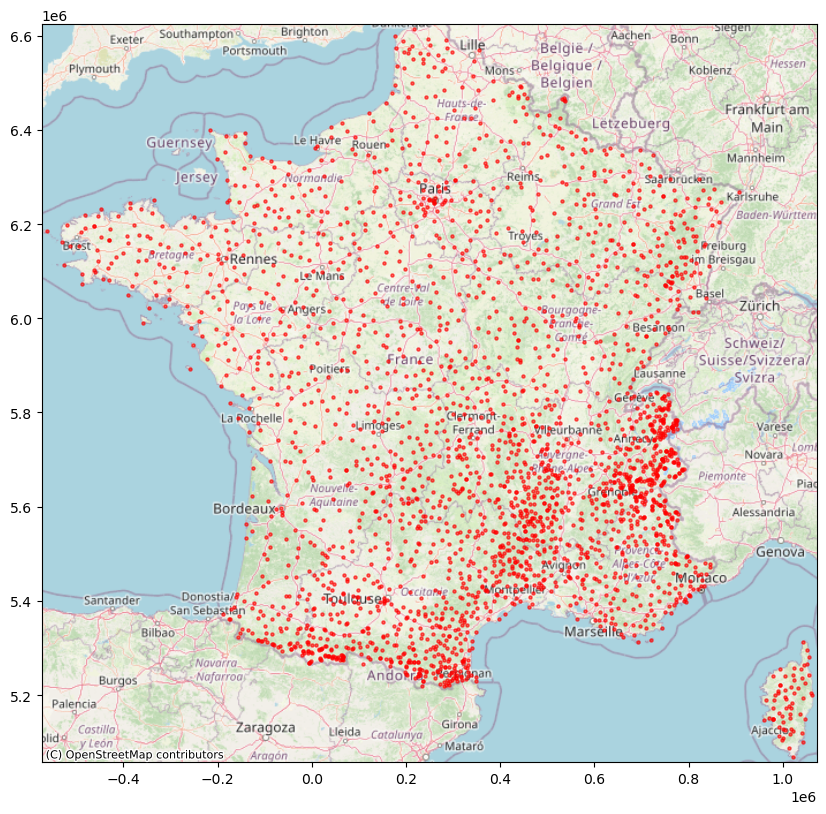

In [90]:
# Création de la figure
fig, ax = plt.subplots(figsize=(10, 10))

# Ajouter les points
gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.6)

# Utiliser une autre source de tuiles, comme OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajuster les limites de la carte selon les bornes des points
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin - 10000, xmax + 10000)  # Ajuster légèrement autour des bornes
ax.set_ylim(ymin - 10000, ymax + 10000)

# Afficher la carte
plt.show()

In [131]:
# Fonction pour récupérer les données avec les identifiants de commande
def fetch_station_data_with_orders(commande_ids, client,compteur):
    all_data = []
    
    for index,commande_id in enumerate(commande_ids):
        url_data = f'https://public-api.meteofrance.fr/public/DPClim/v1/commande/fichier?id-cmde={commande_id}'
        response_data = client.request('GET', url_data)
        
        if response_data.status_code == 201:
            data_csv = response_data.text
            print(f"{compteur+index}. Récupération commande {commande_id}")
            data = pd.read_csv(io.StringIO(data_csv), sep=';', header=0)
            all_data.append(data)
        else:
            print(f"Erreur lors de la récupération des données pour la commande {commande_id}. Statut : {response_data.status_code}")
        
        time.sleep(1.2)  # Pause pour respecter la limite des 50 requêtes/minute
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide s'il n'y a pas de données

In [141]:
# Fonction pour envoyer les commandes et stocker les identifiants par lots de 10
def send_station_orders_in_batches(station_ids, client):
    final_df = pd.DataFrame()  # DataFrame final pour stocker tous les résultats
    compteur = 0

    for i in range(0, len(station_ids), 10):
        batch = station_ids[i:i+10]  # Prendre un lot de 10 stations
        commande_ids = []
        
        # Envoi des commandes pour les 10 stations
        for index,station_id in enumerate(batch):
            url = f'https://public-api.meteofrance.fr/public/DPClim/v1/commande-station/quotidienne?id-station={station_id}&date-deb-periode=2023-01-01T0%3A00%3A00Z&date-fin-periode=2023-12-31T23%3A00%3A00Z'
            response = client.request('GET', url)
            
            if response.status_code == 202:
                commande_id = json.loads(response.text)['elaboreProduitAvecDemandeResponse']['return']
                print(f"{compteur+index}. Commande pour la station {station_id}: {commande_id}")
                commande_ids.append(commande_id)
            else:
                print(f"Erreur lors de la commande pour la station {station_id}. Statut : {response.status_code}")
            
            time.sleep(1.2)  # Pause pour respecter la limite des 50 requêtes/minute
        
        # Récupérer les données pour ce lot de 10 commandes
        batch_df = fetch_station_data_with_orders(commande_ids, client,compteur)
        # Supprimer les caractères non numériques (comme des espaces, des virgules mal placées, etc.)
        try:
            batch_df['RR'] = batch_df['RR'].str.replace(',', '.').str.extract(r'(\d+\.?\d*)').astype(float)

            batch_df_corrected = batch_df[['POSTE', 'RR']].groupby('POSTE').sum()
            
            batch_df_corrected = batch_df_corrected[batch_df_corrected['RR']>0]
            batch_df_corrected = batch_df_corrected.reset_index()
            print(f"Taille dataframe batch: {batch_df_corrected.shape[0]}")
            # Concaténer le DataFrame du lot au DataFrame final
            final_df = pd.concat([final_df, batch_df_corrected], ignore_index=True)
            print(f"Taille dataframe final: {final_df.shape[0]}")
        except:
            pass
        compteur +=10
    
    return final_df

In [144]:
# Étape 1 : Envoyer les commandes par lots de 10 stations et récupérer les résultats
df_results1 = send_station_orders_in_batches(gdf["id"][:1000], client)

0. Commande pour la station 01014002: 783961747875
1. Commande pour la station 01027003: 783961749176
2. Commande pour la station 01034004: 783961750472
3. Commande pour la station 01064001: 783961751771
4. Commande pour la station 01071001: 783961753064
5. Commande pour la station 01072001: 783961754424
6. Commande pour la station 01089001: 783961755722
7. Commande pour la station 01143002: 783961757019
8. Commande pour la station 01185006: 783961758329
9. Commande pour la station 01200002: 783961759627
0. Récupération commande 783961747875
1. Récupération commande 783961749176
2. Récupération commande 783961750472
3. Récupération commande 783961751771
4. Récupération commande 783961753064
5. Récupération commande 783961754424
6. Récupération commande 783961755722
7. Récupération commande 783961757019
8. Récupération commande 783961758329
9. Récupération commande 783961759627
Taille dataframe batch: 9
Taille dataframe final: 9
10. Commande pour la station 01235001: 783961773869
11. Co

In [150]:
# Étape 1 : Envoyer les commandes par lots de 10 stations et récupérer les résultats
df_results2 = send_station_orders_in_batches(gdf["id"][1000:2000], client)

0. Commande pour la station 31042405: 783967322336
1. Commande pour la station 31042407: 783967323675
Erreur lors de la commande pour la station 31048001. Statut : 404
3. Commande pour la station 31069001: 783967326117
4. Commande pour la station 31070004: 783967327400
Erreur lors de la commande pour la station 31080003. Statut : 404
6. Commande pour la station 31085400: 783967329864
7. Commande pour la station 31085401: 783967331209
Erreur lors de la commande pour la station 31139001. Statut : 404
9. Commande pour la station 31147001: 783967333673
Erreur lors de la récupération des données pour la commande 783967322336. Statut : 500
Erreur lors de la récupération des données pour la commande 783967323675. Statut : 500
2. Récupération commande 783967326117
3. Récupération commande 783967327400
4. Récupération commande 783967329864
Erreur lors de la récupération des données pour la commande 783967331209. Statut : 500
6. Récupération commande 783967333673
Taille dataframe batch: 4
Taille

In [155]:
# Étape 1 : Envoyer les commandes par lots de 10 stations et récupérer les résultats
df_results3 = send_station_orders_in_batches(gdf["id"][2000:], client)

Erreur lors de la commande pour la station 66099002. Statut : 404
Erreur lors de la commande pour la station 66117007. Statut : 404
2. Commande pour la station 66119002: 783972312042
Erreur lors de la commande pour la station 66119004. Statut : 404
4. Commande pour la station 66124401: 783972314503
5. Commande pour la station 66124402: 783972315806
Erreur lors de la commande pour la station 66127004. Statut : 404
7. Commande pour la station 66136001: 783972318262
Erreur lors de la commande pour la station 66136013. Statut : 404
9. Commande pour la station 66136401: 783972320701
0. Récupération commande 783972312042
Erreur lors de la récupération des données pour la commande 783972314503. Statut : 500
2. Récupération commande 783972315806
3. Récupération commande 783972318262
Erreur lors de la récupération des données pour la commande 783972320701. Statut : 500
Taille dataframe batch: 3
Taille dataframe final: 3
10. Commande pour la station 66136403: 783972328304
11. Commande pour la st

In [158]:
df_results3

,POSTE,RR
0,66119002,587.4
1,66124402,19.4
2,66136001,244.9
3,66137003,417.1
4,66147402,122.6
...,...,...
523,95446001,476.2
524,95492001,832.0
525,95527001,789.3
526,95580001,779.3


In [161]:
df_rr = pd.concat([df_results1, df_results2, df_results3], axis=0)

In [166]:
df_rr.shape

(1968, 2)

In [163]:
df_rr.to_csv('nom_fichier.csv', index=False)

In [169]:
# Convertir la colonne 'id' en type entier (int) dans le deuxième dataset
gdf['id'] = gdf['id'].astype(int)

df_merged = gdf.merge(df_rr[['POSTE', 'RR']], left_on='id', right_on='POSTE', how='inner')

In [170]:
df_merged

,id,lon,lat,geometry,POSTE,RR
0,1014002,5.669000,46.278167,POINT (631070.193 5825038.283),1014002,1413.8
1,1034004,5.688000,45.769333,POINT (633185.264 5743461.41),1034004,1179.9
2,1064001,5.487167,45.777167,POINT (610828.636 5744711.7),1064001,1182.6
3,1071001,6.080333,46.310333,POINT (676859.573 5830220.535),1071001,1177.9
4,1072001,5.287667,46.204333,POINT (588620.398 5813154.408),1072001,1042.5
...,...,...,...,...,...,...
1963,95446001,2.154333,49.114000,POINT (239819.253 6294226.993),95446001,476.2
1964,95492001,2.406667,49.040333,POINT (267908.945 6281707.833),95492001,832.0
1965,95527001,2.534333,49.015167,POINT (282120.659 6277435.309),95527001,789.3
1966,95580001,2.550667,49.085667,POINT (283938.952 6289409.812),95580001,779.3


In [171]:
# Supposons que df soit votre DataFrame
df_merged.to_parquet('data/pfas_france_2023_dist_site_rr.parquet')